In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

     |████████████████████████████████| 2.1MB 15.8MB/s 
     |████████████████████████████████| 1.2MB 53.3MB/s 
     |████████████████████████████████| 901kB 41.4MB/s 
     |████████████████████████████████| 3.3MB 53.4MB/s 


In [3]:
!ls gdrive/MyDrive/data_image

ls: cannot access 'gdrive/MyDrive/data_image': No such file or directory


In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
import transformers
from transformers import get_linear_schedule_with_warmup
from torchvision import transforms
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "not_humanitarian":
    return 0
  elif text == "infrastructure_and_utility_damage":
    return 1
  elif text == "other_relevant_information":
    return 2
  elif text == "rescue_volunteering_or_donation_effort":
    return 3
  elif text == "affected_individuals":
    return 4

df_train = pd.read_csv("./gdrive/MyDrive/FYP/task_humanitarian_text_img_agreed_lab_train.tsv", sep='\t')
df_train = df_train[['image', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/FYP/task_humanitarian_text_img_agreed_lab_dev.tsv", sep='\t')
df_val = df_val[['image', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/FYP/task_humanitarian_text_img_agreed_lab_test.tsv", sep='\t')
df_test = df_test[['image', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [6]:
data_dir = "./gdrive/MyDrive/FYP/"
class DisasterTweetDataset(Dataset):

  def __init__(self, paths, targets):
    self.paths = paths
    self.targets = targets
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, item):
    path = str(self.paths[item])
    target = self.targets[item]

    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    return {
      'tweet_image': img,
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    paths=df.image.to_numpy(),
    targets=df.label_text.to_numpy(),
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.resnet = torchvision.models.resnext50_32x4d(pretrained=True)
    # for param in self.resnet.parameters():
    #   param.requires_grad = False

    self.bn = nn.BatchNorm1d(1000)
    self.linear1 = nn.Linear(1000, 256)
    self.relu    = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)
    self.linear2 = nn.Linear(256, 5)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, tweet_img):
    output = self.resnet(tweet_img)
    bn_output = self.bn(output)
    linear1_output = self.linear1(bn_output)
    relu_output = self.relu(linear1_output)
    dropout_output = self.dropout(relu_output)
    linear2_output = self.linear2(dropout_output)
    probas = self.softmax(linear2_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    targets = d["targets"].long()
    targets = targets.to(device)

    outputs = model(
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [8]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 50

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.8894290389497971 accuracy 0.7042115572967679
Val   loss 0.6653659937400667 accuracy 0.7695390781563125

Epoch 2/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3810233363672585 accuracy 0.8793666340189357
Val   loss 0.71717864511505 accuracy 0.783567134268537

Epoch 3/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.130015743087841 accuracy 0.9585373816519752
Val   loss 0.9265443292402086 accuracy 0.7765531062124248

Epoch 4/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.06050980065547431 accuracy 0.9833496571988246
Val   loss 1.0347749291667863 accuracy 0.7815631262525049

Epoch 5/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.029863281357260154 accuracy 0.9915115899444988
Val   loss 1.1812043675472812 accuracy 0.7865731462925851

Epoch 6/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.011790585201023895 accuracy 0.9967352269017303
Val   loss 1.257784733755721 accuracy 0.7805611222444889

Epoch 7/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.009875024170350527 accuracy 0.9973881815213842
Val   loss 1.3952235747128725 accuracy 0.7715430861723446

Epoch 8/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.007752894165862003 accuracy 0.9972249428664708
Val   loss 1.4078245712592015 accuracy 0.7905811623246493

Epoch 9/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.00877340655982606 accuracy 0.9970617042115573
Val   loss 1.3989419638814906 accuracy 0.7845691382765531

Epoch 10/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.004735379656363643 accuracy 0.9991838067254326
Val   loss 1.47445289666454 accuracy 0.7965931863727455

Epoch 11/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.009183942876992252 accuracy 0.9975514201762977
Val   loss 1.5076903382700586 accuracy 0.7865731462925851

Epoch 12/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.007445216454421664 accuracy 0.9972249428664708
Val   loss 1.576818145929821 accuracy 0.7895791583166332

Epoch 13/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.003404378007515063 accuracy 0.9986940907606922
Val   loss 1.5893413092172335 accuracy 0.7795591182364728

Epoch 14/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.003551975653272047 accuracy 0.9991838067254326
Val   loss 1.6247822563829166 accuracy 0.7935871743486973

Epoch 15/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.002632777751338507 accuracy 0.999347045380346
Val   loss 1.6485783872859818 accuracy 0.7765531062124248

Epoch 16/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0013021841249929386 accuracy 0.9995102840352595
Val   loss 1.6556607546905677 accuracy 0.7885771543086172

Epoch 17/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.003257635821586009 accuracy 0.9991838067254326
Val   loss 1.7088883826435204 accuracy 0.7875751503006011

Epoch 18/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0004266139747433555 accuracy 1.0
Val   loss 1.799800166978486 accuracy 0.7805611222444889

Epoch 19/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.002170230346851012 accuracy 0.9991838067254326
Val   loss 1.8755515694825187 accuracy 0.782565130260521

Epoch 20/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0017122329923672035 accuracy 0.9995102840352595
Val   loss 1.7796467786122645 accuracy 0.7795591182364728

Epoch 21/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.003376278743476427 accuracy 0.9990205680705191
Val   loss 1.9142689521291427 accuracy 0.7795591182364728

Epoch 22/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.01016283705558087 accuracy 0.9983676134508651
Val   loss 2.0269886967799966 accuracy 0.7755511022044087

Epoch 23/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0030330763284923123 accuracy 0.9988573294156056
Val   loss 1.984617655948987 accuracy 0.7795591182364728

Epoch 24/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.000183219544621919 accuracy 1.0
Val   loss 1.8868401484593513 accuracy 0.7875751503006011

Epoch 25/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0023971737570483054 accuracy 0.999673522690173
Val   loss 2.0181730884674285 accuracy 0.7965931863727455

Epoch 26/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.001351963390552875 accuracy 0.9998367613450865
Val   loss 2.0184272338769267 accuracy 0.7915831663326652

Epoch 27/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 7.351922789995158e-05 accuracy 1.0
Val   loss 2.0800973958971483 accuracy 0.782565130260521

Epoch 28/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.772721931978371e-05 accuracy 1.0
Val   loss 2.133041134473705 accuracy 0.7845691382765531

Epoch 29/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0001392431695534813 accuracy 1.0
Val   loss 2.06333834496105 accuracy 0.7865731462925851

Epoch 30/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.001373305849292449 accuracy 0.9995102840352595
Val   loss 2.204373640281754 accuracy 0.785571142284569

Epoch 31/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.004904845029131913 accuracy 0.999673522690173
Val   loss 2.262405142080896 accuracy 0.7815631262525049

Epoch 32/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.003065759818286724 accuracy 0.999673522690173
Val   loss 2.322066293171947 accuracy 0.7895791583166332

Epoch 33/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0015070383832601825 accuracy 0.9998367613450865
Val   loss 2.3325888617999024 accuracy 0.782565130260521

Epoch 34/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0026876355891157647 accuracy 0.9998367613450865
Val   loss 2.298012062907219 accuracy 0.7745490981963927

Epoch 35/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.000210727957042929 accuracy 0.9998367613450865
Val   loss 2.267698332194298 accuracy 0.7815631262525049

Epoch 36/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.050257722804835e-05 accuracy 1.0
Val   loss 2.3291203985138544 accuracy 0.7935871743486973

Epoch 37/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.7637355854363958e-05 accuracy 1.0
Val   loss 2.3316979488683125 accuracy 0.7895791583166332

Epoch 38/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 8.265372591152495e-06 accuracy 1.0
Val   loss 2.332685951202635 accuracy 0.7865731462925851

Epoch 39/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 6.588344842080191e-06 accuracy 1.0
Val   loss 2.332284392108993 accuracy 0.7875751503006011

Epoch 40/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 4.942404701079094e-06 accuracy 1.0
Val   loss 2.335513276003656 accuracy 0.7865731462925851

Epoch 41/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 4.95376787473032e-06 accuracy 1.0
Val   loss 2.3435501061261648 accuracy 0.785571142284569

Epoch 42/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 5.017567167414102e-06 accuracy 1.0
Val   loss 2.3430893195290414 accuracy 0.7845691382765531

Epoch 43/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 4.428116099245865e-06 accuracy 1.0
Val   loss 2.345512232846684 accuracy 0.7865731462925851

Epoch 44/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 4.221819683559136e-06 accuracy 1.0
Val   loss 2.3452114505427226 accuracy 0.7845691382765531

Epoch 45/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.633461501317709e-06 accuracy 1.0
Val   loss 2.3539413589806784 accuracy 0.785571142284569

Epoch 46/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.3957853068798987e-06 accuracy 1.0
Val   loss 2.3552422409965876 accuracy 0.7845691382765531

Epoch 47/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.387580685446242e-06 accuracy 1.0
Val   loss 2.3593926344599043 accuracy 0.7845691382765531

Epoch 48/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.8369839495297423e-06 accuracy 1.0
Val   loss 2.364676720093167 accuracy 0.7845691382765531

Epoch 49/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 3.203656545158171e-06 accuracy 1.0
Val   loss 2.3659597261557503 accuracy 0.785571142284569

Epoch 50/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.2803515270123076e-06 accuracy 1.0
Val   loss 2.367423197343236 accuracy 0.785571142284569



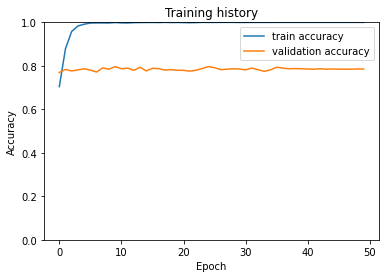

In [9]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/ResNet/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']

# print(start_epoch)


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  # scheduler.step(val_acc)
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/FYP/resnext-human-checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/FYP/resnext-human-checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [10]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/FYP/resnext-human-checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

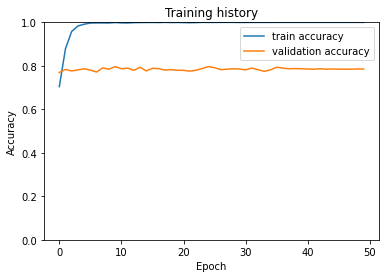

In [11]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [13]:
checkpoint = torch.load("./gdrive/MyDrive/FYP/resnext-human-checkpoint.t7")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']

print(start_epoch)

10


In [14]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweet_imgs = d["tweet_image"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(tweet_img=tweet_imgs)
      preds = torch.max(outputs, dim=1).indices


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['not_humanitarian', 'infrastructure_and_utility_damage', 'other_relevant_information', 'rescue_volunteering_or_donation_effort', 'affected_individuals'], digits = 4))

                                        precision    recall  f1-score   support

                      not_humanitarian     0.8173    0.8790    0.8470       504
     infrastructure_and_utility_damage     0.7701    0.8272    0.7976        81
            other_relevant_information     0.8800    0.7489    0.8092       235
rescue_volunteering_or_donation_effort     0.6230    0.6032    0.6129       126
                  affected_individuals     0.5000    0.2222    0.3077         9

                              accuracy                         0.8000       955
                             macro avg     0.7181    0.6561    0.6749       955
                          weighted avg     0.8001    0.8000    0.7976       955

